In [198]:
import sys
sys.path.insert(0, "../../")

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import flax.linen as nn
from matplotlib import pyplot as plt
import module.util as util
import optax
from tqdm import tqdm

## Diffusion Modelling

We are now trying out yet a different diffusion process:
$$
dx =  \alpha \sqrt{2 t}\, dW
$$
This gives rise to the following time-dependent random variable
$$
x_t = x_0 + \alpha t \,\xi_t
$$
where $\xi_t$ are standard normals.

In [199]:
key = jax.random.PRNGKey(0)

In [200]:
space_dim = 2

def get_samples(key, N = 1000):
    z = jax.random.uniform(key, (N,))*2*jnp.pi
    
    key, _ = jax.random.split(key)
    x1 = jax.random.normal(key, (N,))*0.05 + jnp.cos(z)*0.6 + jnp.sign(z - jnp.pi)*0.3
    key, _ = jax.random.split(key)
    x2 = jax.random.normal(key, (N,))*0.05 + jnp.sin(z)*0.6 + jnp.sign(z - jnp.pi)*0.3*z


    return jnp.stack((x1, x2), axis = -1)


In [201]:
#
# Diffusion Parameters
#
alpha = 0.1

T = 1/2/alpha


print("final time = ", T)

final time =  5.0


0.8173328


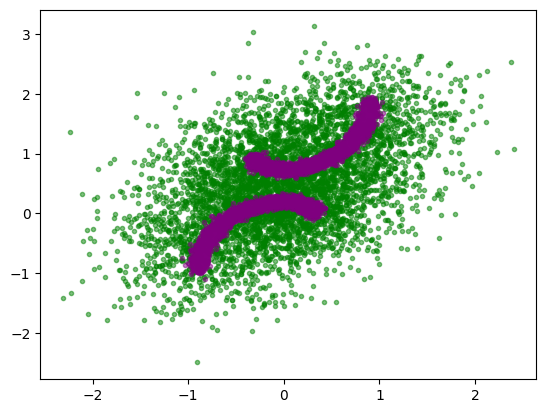

In [202]:
N = 5000
t = T

key, _ = jax.random.split(key)
x0 = get_samples(key, N)
key, _ = jax.random.split(key)
xi = jax.random.normal(key, (N, space_dim))
xt = x0 + alpha * t *xi
print(jnp.std(xt))

xs = jnp.linspace(-2, 2, num = 20)
ys = jnp.linspace(-1, 1, num = 20)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

plt.scatter(xt[:,0], xt[:,1], color = "green", alpha = 0.5, marker = ".")
plt.scatter(x0[:,0], x0[:,1], color = "purple", alpha = 0.5, marker = ".")

### Define Score Model

In [203]:
act = lambda x: nn.softplus(x)

class ScoreModel(nn.Module):
  @nn.compact
  def __call__(self, x, t):

    # space embedding
    a = nn.Dense(24)(x)
    a = act(a)
    a = nn.Dense(48)(a)
    a = act(a)

    # time embedding
    b = nn.Dense(24)(t)
    b = act(b)
    b = nn.Dense(48)(b)
    b = act(b)

    # full
    c = a + b

    # predict
    c = nn.Dense(64)(c)
    c = act(c)
    output = nn.Dense(2)(c)

    return output

### Optimisation

In [204]:
model = ScoreModel()
param = model.init(key, jnp.empty((space_dim,)), jnp.empty((1,)))

In [205]:
@jax.jit
def calc_loss(param, samples, t, w):
    eval = model.apply(param, samples, t)
    a = jnp.sum(eval ** 2, axis = -1)
    c = 2*jnp.sum(w*jax.jvp(model.apply, (param, samples, t), (util.t_zeros_like(param), w, jnp.zeros_like(t)))[1], axis = -1)

    return jnp.mean(a + c)

@jax.jit
def grad_loss(param, samples, t, w):
    l = lambda param: calc_loss(param, samples, t, w)
    grad = jax.vjp(l, param)[1](jnp.array(1.))
    return grad[0]

In [206]:
losses = []
param = model.init(key, jnp.empty((space_dim,)), jnp.empty((1,)))

In [207]:
N = 3000
optimiser = optax.adam(1e-2)
opt_state = optimiser.init(param)

In [208]:
for i in tqdm(range(1000)):
    key, _ = jax.random.split(key)
    x0 = get_samples(key, N)
    key, _ = jax.random.split(key)
    xi = jax.random.normal(key, (N, space_dim))

    key, _ = jax.random.split(key)
    t = jax.random.uniform(key, (N, 1)) * T * 2 - T  # interestingly you can use negative times and it maybe helps

    xt = x0 + alpha * t * xi
    key, _ = jax.random.split(key)
    w = jax.random.normal(key, (N, space_dim))

    loss = calc_loss(param, xt, t, w)
    losses.append(loss)
    grad = grad_loss(param, xt, t, w)

    updates, opt_state = optimiser.update(grad, opt_state)
    param = optax.apply_updates(param, updates)

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 60/1000 [00:03<00:33, 28.03it/s]

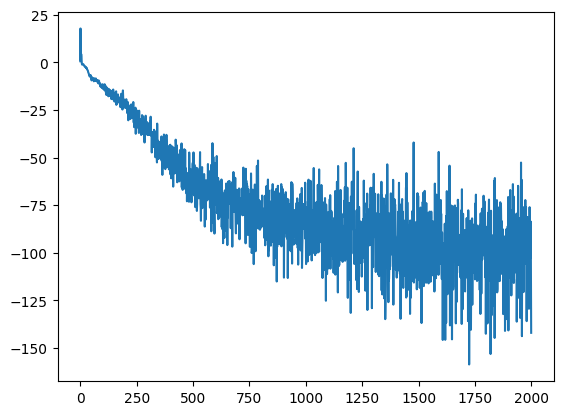

In [183]:
plt.plot(losses)
# plt.ylim(-800, 300)

## Sample using the Score-Function
After obtaining the score function for all times, we run a special backwards SDE whose distribution evolves exactly backwards in time compared to the forward diffusion process.
$$
dx = 2\alpha^2 (T - t) \, \nabla \log p(x, T - t)dt + \sigma dW
$$

In [184]:
N = 2000

x = jax.random.normal(key, (N, space_dim))
epsilon = 0.01
t = 0

In [185]:
while t + epsilon < T:
    t_eval = T - t
    key, _ = jax.random.split(key)
    dx = 2 * alpha ** 2 * t_eval  * model.apply(param, x, jnp.ones((N, 1))*t_eval)*epsilon + alpha * jnp.sqrt(2 * t_eval) * jnp.sqrt(epsilon) * jax.random.normal(key, (N, space_dim))
    x = x + dx
    t = t + epsilon

# # purely thermal
# while t + epsilon < 40:
#     t_eval = 0
#     key, _ = jax.random.split(key)
#     dx = model.apply(param, x, jnp.ones((N, 1))*t_eval)*epsilon + jnp.sqrt(2 * epsilon) * jax.random.normal(key, (N, space_dim))*0
#     x = x + dx
#     t = t + epsilon

(-2.0, 2.0)

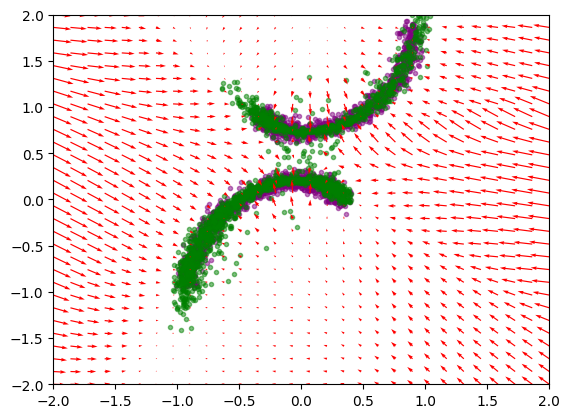

In [186]:
key, _ = jax.random.split(key)
x0 = get_samples(key, N)

xs = jnp.linspace(-2, 2, num = 30)
ys = jnp.linspace(-2, 2, num = 30)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

score_approx = model.apply(param, coord, jnp.ones((30, 30, 1)) * 0)

plt.scatter(x0[:,0], x0[:,1], color = "purple", alpha = 0.5, marker = ".")
plt.scatter(x[:,0], x[:,1], color = "green", alpha = 0.5, marker = ".")
plt.quiver(xx, yy, score_approx[...,0], score_approx[...,1], color = "r")
plt.xlim(-2, 2)
plt.ylim(-2, 2)

In [ ]:
# sausage